In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

SOS_token = 0
EOS_token = 1


cpu


In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [5]:
def normalizeString(s):
    # Nweh and English vocabularies
    nweh_vocab = [
        # Basic characters and punctuation
        ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 'Àå',
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?',

        # Uppercase letters
        'A', 'B', 'C', 'D', 'E', '∆è', '∆ê', 'F', 'G', 'GH', 'H', 'I', 'J', 'K', 'KH', 'L', 'M', 'N', '≈ä', 'O', '∆Ü', 'P',
        'PF', 'R', 'S', 'T', 'TS', 'U', '…Ñ', 'V', 'W', 'Y', 'Z',

        # Lowercase letters
        'a', 'b', 'c', 'd', 'e', '…ô', 'Œµ', 'f', 'g', 'gh', 'h', 'i', 'j', 'k', 'kh', 'l', 'm', 'n', '≈ã', 'o', '…î', 'p',
        'pf', 'r', 's', 't', 'ts', 'u', ' â', 'v', 'w', 'y', 'z',

        # Consonant combinations
        'br', 'gb', 'kp', 'ny',

        # Vowels with tones
        'aÃÄ', 'eÃÄ', 'uÃÄ', 'oÃÄ', ' âÃÄ',  # Low tone
        'aÃÇ', 'eÃÇ', 'uÃÇ', 'oÃÇ', ' âÃÇ',  # Falling tone
        'aÃå', 'eÃå', 'uÃå', 'oÃå', ' âÃå',  # Rising tone
        'aÃÑ', 'eÃÑ', 'uÃÑ', 'oÃÑ', ' âÃÑ',  # Level or mid tone
        '√°', '√©', '√≠', '√≥', '√∫', ' âÃÅ',  # High tone

        # Special characters
        '…ë', '…ì', '…ó', '…®',

        # Tonal variations
        '√†', '√°', 'ƒÅ', '√¢', '«é',
        '…ëÃÄ', '…ëÃÅ', '…ëÃÑ', '…ëÃÇ', '…ëÃå',
        '√®', '√©', 'ƒì', '√™', 'ƒõ',
        '…ôÃÄ', '…ôÃÅ', '…ôÃÑ', '…ôÃÇ', '…ôÃå',
        '…õÃÄ', '·Ω≥', '…õÃÑ', '…õÃÇ', '…õÃå',
        '√¨', '√≠', 'ƒ´', '√Æ', '«ê',
        '√≤', '√≥', '≈ç', '√¥', '«í',
        '…îÃÄ', '…îÃÅ', '…îÃÑ', '…îÃÇ', '…îÃå',
        '√π', '√∫', '≈´', '√ª', '«î',
        ' âÃÄ', ' âÃÅ', ' âÃÑ', ' âÃÇ', ' âÃå',
        '≈ãÃÄ', '≈ãÃÅ', '≈ãÃÑ', '≈ãÃÇ', '≈ãÃå',

        # Double vowels
        '√†√†', '√°√°', 'ƒÅƒÅ',
        '…ëÃÄ…ëÃÄ', '…ëÃÅ…ëÃÅ', '…ëÃÑ…ëÃÑ',
        '√®√®', '√©√©', 'ƒìƒì',
        '…ôÃÄ…ôÃÄ', '…ôÃÅ…ôÃÅ', '…ôÃÑ…ôÃÑ',
        '…õÃÄ…õÃÄ', '·Ω≥·Ω≥', '…õÃÑ…õÃÑ',
        '√¨√¨', '√≠√≠', 'ƒ´ƒ´',
        '√≤√≤', '√≥√≥', '≈ç≈ç',
        '…îÃÄ…îÃÄ', '…îÃÅ…îÃÅ', '…îÃÑ…îÃÑ',
        '√π√π', '√∫√∫', '≈´≈´',
        ' âÃÄ âÃÄ', ' âÃÅ âÃÅ', ' âÃÑ âÃÑ',

        # Mixed tone double vowels
        '√¨√†', '√≠√°', 'ƒ´ƒÅ',
        '√¨…ëÃÄ', '√≠…ëÃÅ', 'ƒ´…ëÃÑ',
        '√¨√®', '√≠√©', 'ƒ´ƒì',
        '√π√†', '√∫√°', '≈´ƒÅ'
    ]

    eng_vocab = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@',
                 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                 'Y', 'Z', '[', '\\', ']', '^', '_', '`',
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                 'y', 'z', '{', '|', '}', '~']

    s = s.lower().strip()

    # Normalize unicode to ASCII for non-Nweh characters
    s = unicodeToAscii(s)

    # Create a set of allowed characters based on both vocabularies
    allowed_chars = set(nweh_vocab + eng_vocab)

    # Remove characters not in the allowed set
    s = ''.join(c for c in s if c in allowed_chars or unicodedata.category(c) != 'Mn')

    # Replace certain punctuation with space-punctuation-space for consistency
    s = re.sub(r"([.!?])", r" \1", s)

    return s.strip()


In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./data/train.txt', encoding='utf-8'). \
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



In [8]:
def prepareData(lang1, lang2, reverse=True):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [9]:
input_lang, output_lang, pairs = prepareData('nweh', 'english', True)
print(random.choice(pairs))

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
["'no, for there may not be enough for us and you .", '≈ãjw…îmy…î .‚Äô ew…î≈ãk…ôbangwi ebi e le furi, e le lo ngh…î a njw…îb…ôv…õt-nk…õ º, tangwingh…î']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden



In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden



In [12]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights



In [13]:
def indexesFromSentence(lang, sentence):
    words = []

    for word in sentence.split(' '):
      words.append(lang.word2index.get(word,0))
    return words

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'nweh', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader



In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        _, predicted = decoder_outputs.max(2)
        correct = predicted.eq(target_tensor)
        num_correct = correct.sum().item()
        total_correct += num_correct
        total_samples += target_tensor.size(0) * target_tensor.size(1)

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(dataloader)


    return average_loss, accuracy



In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    plot_accuracy = []
    print_accuracy_total = 0  # Reset every print_every
    plot_accuracy_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        print_accuracy_total += accuracy
        plot_accuracy_total += accuracy

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

            print_accuracy_avg = print_accuracy_total / print_every
            print_accuracy_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_accuracy_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            plot_accuracy_avg = plot_accuracy_total / plot_every
            plot_accuracy.append(plot_accuracy_avg)
            plot_accuracy_total = 0


    showPlot(plot_losses)
    showPlot(plot_accuracy)

    return plot_losses, plot_accuracy


In [17]:
import matplotlib.pyplot as plt
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig("./img/losses_up.png")



In [18]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn



In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
from matplotlib import ticker


def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig("./img/test.png")
    plt.show()


def evaluateAndShowAttention(input_sentence):
    hidden_size = 128
    input_lang, output_lang, pairs = prepareData('nweh', 'english', True)
    encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    encoder.load_state_dict(torch.load('volingual_encoder.pt'))
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
    decoder.load_state_dict(torch.load('volingual_decoder.pt'))
    encoder.eval()
    decoder.eval()
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    # The if statement below removes the EOS token from the output words
    if '<EOS>' in output_words:
        output_words = output_words[:-1]  # Removing the last element, which is EOS

    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    return ' '.join(output_words)

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
nweh 1791
eng 1675
0m 39s (- 25m 50s) (5 2%) 4.7421
0m 39s (- 25m 50s) (5 2%) 0.5089
1m 17s (- 24m 30s) (10 5%) 2.6347
1m 17s (- 24m 30s) (10 5%) 0.6236
2m 1s (- 25m 4s) (15 7%) 2.2553
2m 1s (- 25m 4s) (15 7%) 0.6380
2m 39s (- 23m 52s) (20 10%) 2.1053
2m 39s (- 23m 52s) (20 10%) 0.6758
3m 11s (- 22m 21s) (25 12%) 2.0127
3m 13s (- 22m 31s) (25 12%) 0.6813
3m 57s (- 22m 28s) (30 15%) 1.9299
3m 57s (- 22m 28s) (30 15%) 0.6858
4m 30s (- 21m 16s) (35 17%) 1.8951
4m 32s (- 21m 25s) (35 17%) 0.6899
5m 7s (- 20m 28s) (40 20%) 1.8429
5m 7s (- 20m 28s) (40 20%) 0.6935
5m 37s (- 19m 23s) (45 22%) 1.7734
5m 37s (- 19m 23s) (45 22%) 0.6991
6m 7s (- 18m 23s) (50 25%) 1.7607
6m 7s (- 18m 23s) (50 25%) 0.7028
6m 37s (- 17m 29s) (55 27%) 1.7217
6m 37s (- 17m 29s) (55 27%) 0.7081
7m 6s (- 16m 35s) (60 30%) 1.7027
7m 6s (- 16m 35s) (60 30%) 0.7136
7m 36s (- 15m 48s) (65 32%) 1.6083
7m 36s (- 15m 48s)

<Figure size 640x480 with 0 Axes>

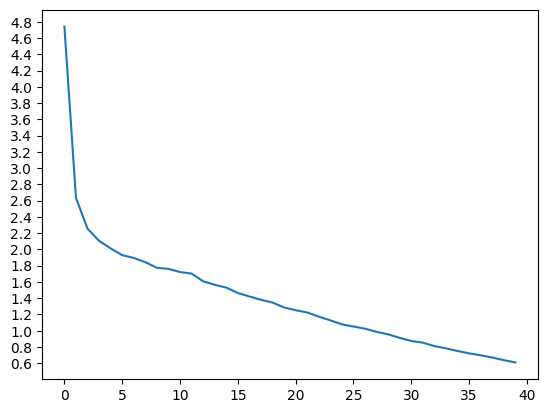

<Figure size 640x480 with 0 Axes>

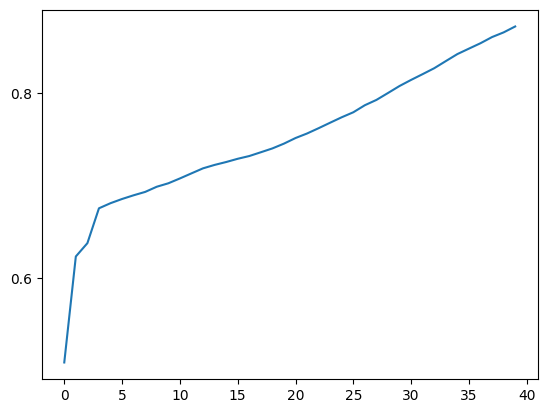

In [21]:
hidden_size = 128
batch_size = 512

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 200, print_every=5, plot_every=5)

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

0m 28s (- 46m 14s) (5 1%) 0.5428
0m 28s (- 46m 14s) (5 1%) 0.8927
0m 54s (- 44m 43s) (10 2%) 0.4890
0m 54s (- 44m 43s) (10 2%) 0.9030
1m 22s (- 44m 27s) (15 3%) 0.4640
1m 22s (- 44m 27s) (15 3%) 0.9124
1m 50s (- 44m 23s) (20 4%) 0.4301
1m 50s (- 44m 23s) (20 4%) 0.9199
2m 18s (- 43m 49s) (25 5%) 0.3962
2m 18s (- 43m 49s) (25 5%) 0.9278
2m 46s (- 43m 34s) (30 6%) 0.3715
2m 46s (- 43m 34s) (30 6%) 0.9345
3m 14s (- 43m 9s) (35 7%) 0.3433
3m 14s (- 43m 9s) (35 7%) 0.9410
3m 45s (- 43m 16s) (40 8%) 0.3207
3m 45s (- 43m 16s) (40 8%) 0.9464
4m 14s (- 42m 53s) (45 9%) 0.2938
4m 14s (- 42m 53s) (45 9%) 0.9516
4m 45s (- 42m 51s) (50 10%) 0.2758
4m 45s (- 42m 51s) (50 10%) 0.9559
5m 14s (- 42m 24s) (55 11%) 0.2519
5m 14s (- 42m 24s) (55 11%) 0.9609
5m 42s (- 41m 48s) (60 12%) 0.2316
5m 42s (- 41m 48s) (60 12%) 0.9650
6m 10s (- 41m 16s) (65 13%) 0.2167
6m 10s (- 41m 16s) (65 13%) 0.9678
6m 38s (- 40m 50s) (70 14%) 0.1989
6m 38s (- 40m 50s) (70 14%) 0.9718
7m 7s (- 40m 22s) (75 15%) 0.1800
7m 7s (-

<Figure size 640x480 with 0 Axes>

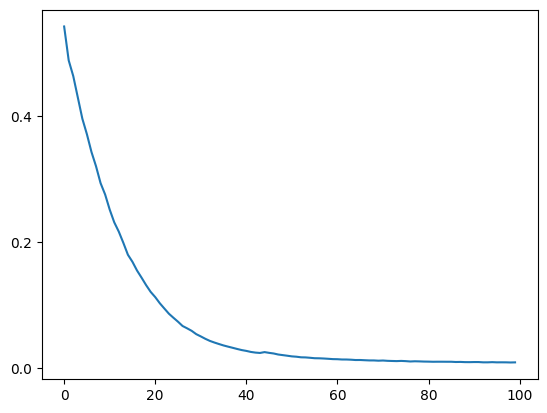

<Figure size 640x480 with 0 Axes>

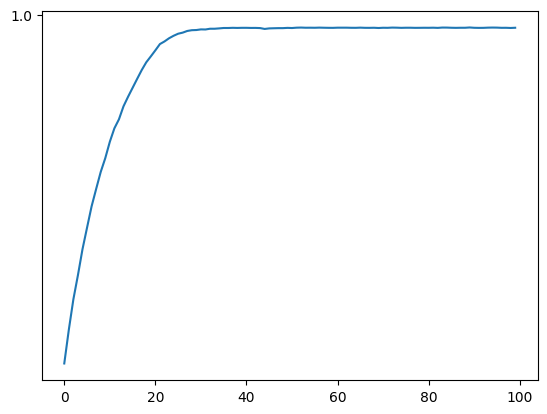

In [22]:
los, acc= train(train_dataloader, encoder, decoder, 500, print_every=5, plot_every=5)

In [23]:

import matplotlib.pyplot as plt

def plot_graph(los):
    # Calculate the x-axis ticks based on los length
    x_ticks = [(i+1)*5 for i in range(len(los))]

    # Define the custom ticks
    custom_ticks = []
    for tick in x_ticks:
      if tick % 50 == 0:
        custom_ticks.append(tick)
      else:
        custom_ticks.append('')
# plotting a graph of the loss function which shows th loss decreasing as the number of epochs increases
    plt.plot(x_ticks, los)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(x_ticks, labels=custom_ticks)  # Set custom ticks
    plt.grid(False)
    plt.show()

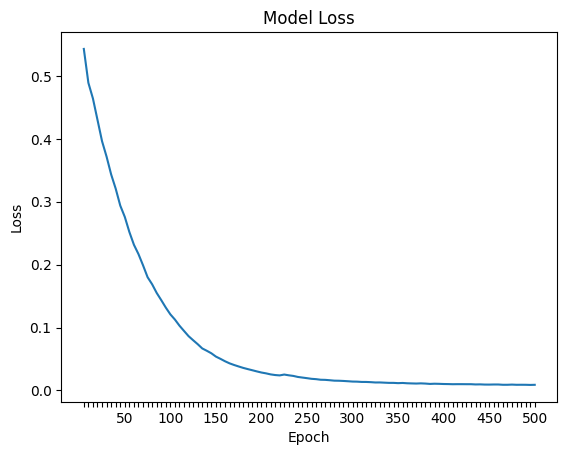

In [24]:
# plotting a graph of the loss function which shows the loss decreasing as the number of epochs increases
plot_graph(los)

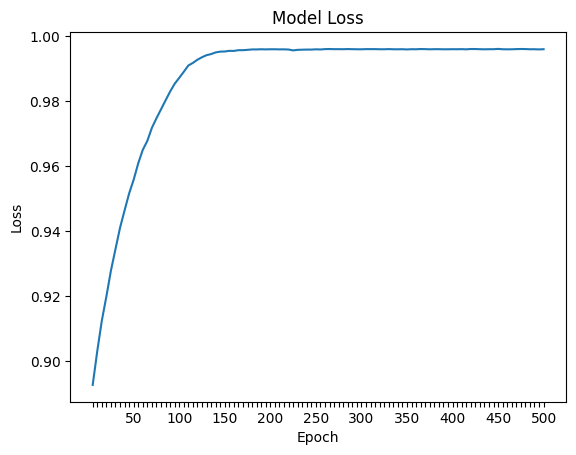

In [25]:
# plotting a graph of the accuracy function which shows the accuracy increasing as the number of epochs increases
plot_graph(acc)

In [26]:
# Save the encoder and decoder models
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> cocoa
= akaka
< k…î≈ã…î a patya, nd…õm, egi b…õ º mby…õp-ebu≈ã-nkr…ô a ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ

> like labor pains upon a pregnant woman, and they will not escape .
= ase, ≈ãw…î g…õ ku º…île k…ôb…î .
< ase, ≈ãw…î g…õ ku º…île k…ôb…î mbo mi e ge z…î, ≈ãnya by…îny…î≈ã b…ônu-nd…õm b…õ º f…õ º b…ôl…õ º g…õ a na nsa≈ãa

> to be
= mb…ô
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> until it came and stopped over the place where the child was .
= ≈ãbin tu≈ã…î gap a b…õteleh…õm m…ônkr…î ngh…ô, ‚Äúby…î gh…î ≈ãpite nf…õ º al…® º za ≈ãw…îa m…ô, by…î
< ≈ãbin tu≈ã…î gh…î ≈ãpite nf…õ º al…® º za ≈ãw…îa m…ô, by…î b…ônu nch…õm mi b…ôm…®kte ngh…ô b…ô gh…î al…® º a k…î

> he was backbiting your name yesterday .
= a keh zogo mbia≈ãta leli≈ã loh .
< a h â…ô h â…ô ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ ny…õ

> if when he returns tell me .
= a bigla, o so≈ã a geh .
< a h â…ô h â…ô ndya, ndya,

In [27]:
# saving the encoder model which is the model that converts the input language to the hidden state
torch.save(encoder.state_dict(), 'volingual_encoder.pt')

In [28]:
# saving the decoder model which is the model that converts the hidden state to the output language
torch.save(decoder.state_dict(), 'volingual_decoder.pt')

In [29]:
# Load the encoder and decoder models
encoder.load_state_dict(torch.load('volingual_encoder.pt'))
decoder.load_state_dict(torch.load('volingual_decoder.pt'))
encoder.eval()  # Set the model to evaluation mode
decoder.eval()  # Set the model to evaluation mode

AttnDecoderRNN(
  (embedding): Embedding(1675, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=1675, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
# open the test data and read the lines
test_data = open('./data/test_en.txt', 'r').readlines()
predictions = []    # Create an empty list to store the predictions
for line in test_data:   # Loop through the test data
    translation = evaluateAndShowAttention(line)   # Translate the test data
    predictions.append(translation)   # Append the translation to the predictions list

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = He/she will cheat, you will see.

output = ebw…î-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = He demolished a house.

output = ebw…î-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = keep

output = ebw…î-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = It will be good later on in the day.

output = achy…õ-by…î a le l…îk van nf…ôa ijip
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = Everyone was greatly surprised. But Jesus ordered them not to tell anyone what had happened.

output 

In [31]:
# Specify path to save the predictions
predictions_file_path = "./data/predictions.txt"  # Path to save the predictions

# Write predictions to the file
with open(predictions_file_path, 'w') as f:
    for prediction in predictions:
        f.write(prediction + '\n')

In [32]:
# Load the nweh test data
ref_data = open('./data/test_nweh.txt', 'r').readlines()
refs = []     # Create an empty list to store the reference data
for line in ref_data:    # Loop through the reference data
    refs.append(line.split(" "))        # Append the reference data to the refs list

In [33]:
## I tried printing out the arrays to actually see what they contained

In [34]:
print(ref_data)

['√Ä b√†b-e, √≤ ji…î-…î.\n', '√Ä l√®h b√≤g ndiah.\n', 'le nale\n', 'A g âÃÄ- â e b…îÃÄ≈ã-≈ã.\n', 'ngy…õt. Jis…îs a le shu º…î gap ngh…ô boÃÅ b…õ º so≈ã am…î º ≈ãw…î, ≈ãÃÅ bin dy…î aÃÅ mboÃÅ boÃÅ ngh…ô, ‚ÄúB…ô ÃÅfya ≈ãw…î ÃÅjuÃÅn…õ ÃÅebu≈ã a d âÃÅ.‚Äù \n', 'a le so≈ã…î √° gap. El…ô≈ã giÃÇ boÃÅ le jy…î gi, b√≥ le shy…õla gi, √©m…î º by…î a nkoÃÅ √© le b…î≈ã\n', 'le pite\n', 'gi √© gh…ô en…õt b…ônu my…î √© te kw…î lefw…î Nd…õm b…îÃÅ.\n', '≈ä kw…õ lekw…õ aÃÅ mboÃÅ eshw…î g…õ,\n', '√Ä f…ôa-a e ba≈ã-≈ã.\n', 'AboÃÅ-lu≈ã…îÃÅza a b…îÃÅ≈ã ety…îÃÅ\n', 'B…î≈ã lekak aÃÅ mboÃÅ Achy…õÃÅ-by…î,\n', 'b…ôby…î s…õk ngha aÃÅ ny…õÃÅ Achy…õÃÅ-by…î. B…ôby…î l…îk m…ô le b…õm-Nd…õm ≈ãa≈ã, te ma le jy…î el…® º\n', 'Tem a ny√† g√¨!\n', 'G√≤ b…îÃÄn…îÃÄ ≈ãkap, g√≤ ju…î t√®c√¨y√¨ t√®betu.\n', '≈ä s…õnta Achy…õÃÅ-by…î ngh…î ntat nd…îk ndata anu jy…î, ngh…ô Satan juÃÅn…õÃÅ a tu≈ã…î aÃÅ ny…õÃÅ\n', "√Ä n√† mb√¨√†≈ãta g√≤ t…îÃÄ' √† gih.\n", '√Ä leih ba≈ã.\n', '√â la el…ô≈ã meÃå, Jis…îs a ly…î √° mb√≥ baji ºi √° mb√≥ j…® 

In [35]:
print(predictions)

['ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'achy…õ-by…î a le l…îk van nf…ôa ijip', 'ebw…î-betat,', 'le ta', 'ebw…î-betat,', 'le kw…î', 'ebw…î-betat,', 'achy…õ-by…î a fya g…õ a ch…õ≈ã…ô lefw…î ra', 'achy…õ-by…î a le ju º…î g…õ, t…õmby…î .‚Äù', 'ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'le ch…®', 'achy…õ-by…î a le l…îk nk…î≈ãte', 'achy…õ-by…î a by…õba g…õ, m…ôeta jy…î,', 'ebw…î-betat,', 'ebw…î-betat,', 'a le so≈ã…ô a mbo m…ô .‚Äù', 'mbagte', 'ebw…î-betat,', 'ebw…î-betat,', 'le sa≈ã', 'le tu≈ã', 'ebw…î-betat,', 'ebw…î-betat,', 'le sa≈ã', 'le ta', 'ebw…î-betat,', 'm…ôndya map a', 'ebw…î-betat,', 'ebw…î-betat,', 'le kap e ku ºu, bo le f…ôm…ô,', 'ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'fw…õt-fw…õt-nd…õm a le bin nch…õ º at…î-ndya', 'ebw…î-betat,', 'le jy…î e ly…î bap, mba≈ãa', 'ebw…î-betat,', 'abo za a b…î≈ã lekak .', 'nkhangee', 'ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'ebw…î-betat,', 'mbagte', 'a ny…õ b…ônu b…ôb…õ º e ≈ãwete, ≈ãmbwate', 'ebw…î-bet

In [36]:
## I think there was an issue with the right use of where we imported the bleu_score. Below I imported from the Natural Language Toolkit and it works

In [37]:
from nltk.translate.bleu_score import sentence_bleu

# Calculate BLEU score for each pair of reference and prediction
total_bleu_score = 0
for ref, pred in zip(ref_data, predictions):   # Loop through the reference and prediction data
    bleu_score = sentence_bleu([ref], pred)     # Calculate the BLEU score
    total_bleu_score += bleu_score              # Add the BLEU score to the total

# Average BLEU score
average_bleu_score = total_bleu_score / len(ref_data)     # Calculate the average BLEU score
print("Average BLEU Score:", average_bleu_score)       # Print the average BLEU score

Average BLEU Score: 0.006842824844768335


/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

In [38]:
## Tried out a smoothing function to get better results given that I was having issues with previous runs. Smoothing can help mitigate the issue of zero-count n-grams and provide a more accurate evaluation of the similarity between the reference and prediction data.

In [39]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define a smoothing function
smoothing_function = SmoothingFunction().method1

# Calculate BLEU score for each pair of reference and prediction
total_bleu_score = 0     # Initialize the total BLEU score
for ref, pred in zip(ref_data, predictions):      # Loop through the reference and prediction data
    bleu_score = sentence_bleu([ref], pred, smoothing_function=smoothing_function)    # Calculate the BLEU score
    total_bleu_score += bleu_score    # Add the BLEU score to the total

# Average BLEU score
average_bleu_score = total_bleu_score / len(ref_data)    # Calculate the average BLEU score
print("Average BLEU Score with Smoothing:", average_bleu_score)   # Print the average BLEU score

Average BLEU Score with Smoothing: 0.018810786972208785


In [40]:
# Commented out the previuos
# from torchtext.data.metrics import bleu_score

# bleu_score(ref_data, predictions)

In [41]:
ref_data[1]

'√Ä l√®h b√≤g ndiah.\n'

In [42]:
predictions[1]

'ebw…î-betat,'